#### Import Dependencies


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import mlflow.pyfunc
import pickle
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, accuracy_score, r2_score

from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

c:\Users\ASUS PC\Desktop\AMDARI INTERNSHIP\optiSecure\abahenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [4]:
data = pd.read_csv(r"C:\Users\ASUS PC\Desktop\AMDARI INTERNSHIP\Med_Optix\Optix_repo\Model\cleaned_df.csv", parse_dates=['date'])
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date')

### Split Data according, from date to most recent date trend. Older version is used to train and newer entries are used to test.

In [5]:
split_idx = int(len(data) * 0.8)
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

### Adopt Mutual Info for Feature Selection

In [6]:
mi_data = data.drop(columns=['hospital_id', 'ward_code', 'date'])
features = [col for col in mi_data.columns if col not in ['date', 'admissions']]


<Figure size 1000x800 with 0 Axes>

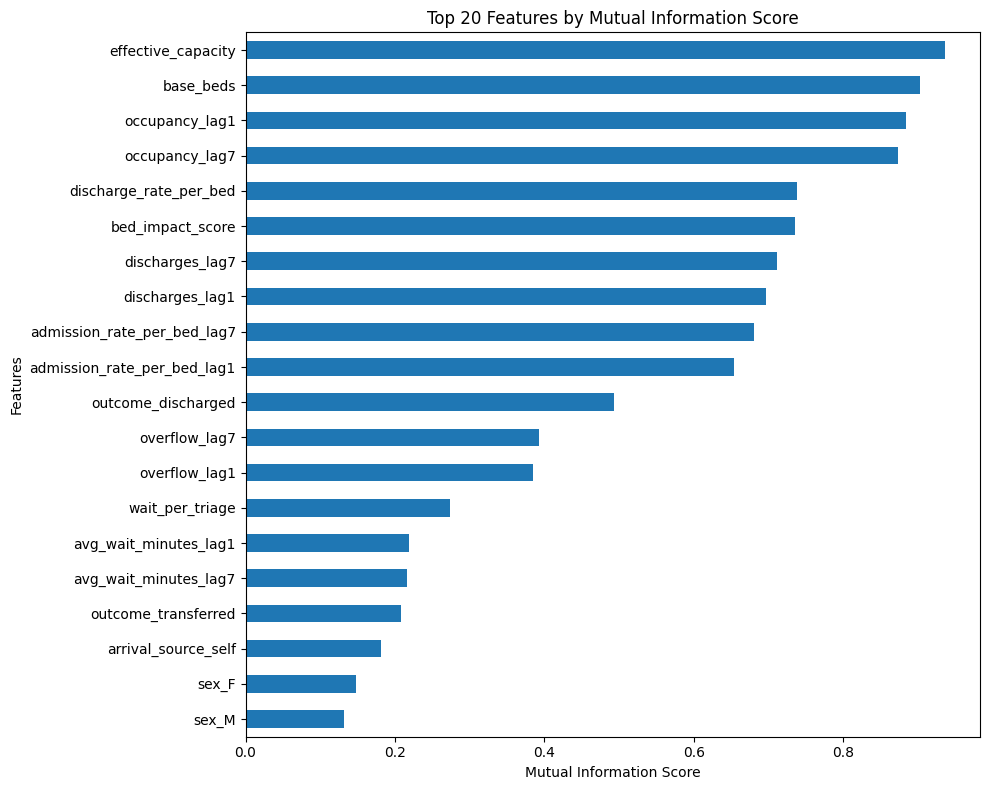

In [7]:
from sklearn.feature_selection import mutual_info_regression

X = train_data[features]
y = train_data['admissions']

mi_scores = mutual_info_regression(X, y, random_state=42)

mi_df = pd.DataFrame({
    'feature': features,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

plt.figure(figsize=(10, 8))
mi_df.head(20).plot(x='feature', y='mi_score', kind='barh', figsize=(10, 8), legend=False)
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.title('Top 20 Features by Mutual Information Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('mutual_info_scores.png', dpi=150, bbox_inches='tight')
plt.show()

### Split the data with exogenous features sampled on a weekly basis

In [8]:
top_features = mi_df['feature'].head(20).tolist()
exog_features = top_features

data = data.set_index('date')

weekly_target = data["admissions"].resample("W").sum()
weekly_exog = data[exog_features].resample("W").mean()

train_size = int(len(weekly_target) * 0.8)
train_y = weekly_target.iloc[:train_size]
test_y = weekly_target.iloc[train_size:]

train_exog = weekly_exog.iloc[:train_size]
test_exog = weekly_exog.iloc[train_size:]

SARIMAX Model - MAE: 63.54, RMSE: 79.78, R2: 0.88


statsmodels.tsa.statespace.sarimax.SARIMAX

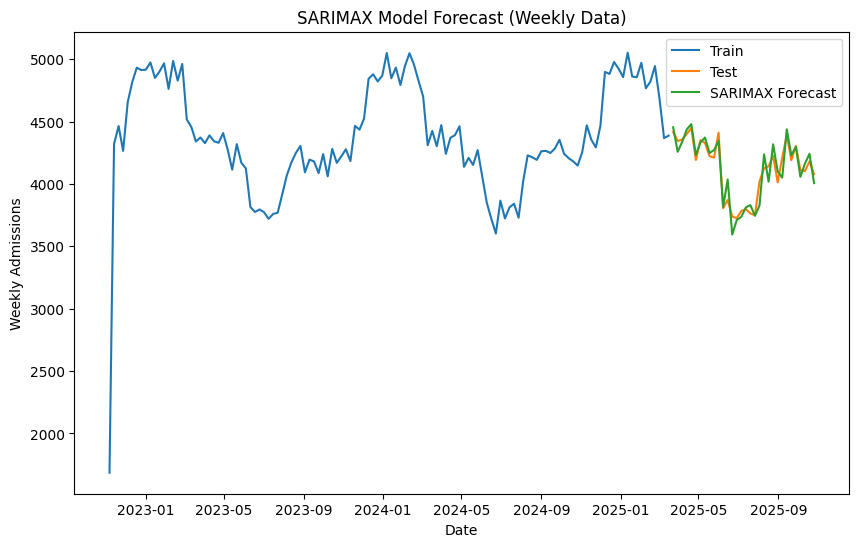

In [10]:
with mlflow.start_run(run_name="SARIMAX Model"):
    sarimax_model = SARIMAX(
        train_y,
        exog=train_exog,
        order=(1, 0, 1),
        seasonal_order=(1, 0, 1, 7)
    )
    sarimax_model = sarimax_model.fit(disp=False)
    
    sarimax_forecast = sarimax_model.forecast(
        steps=len(test_y),
        exog=test_exog
    )
    
    sarimax_mae = mean_absolute_error(test_y, sarimax_forecast)
    sarimax_rmse = np.sqrt(mean_squared_error(test_y, sarimax_forecast))
    sarimax_r2 = r2_score(test_y, sarimax_forecast)
    
    mlflow.log_param("model_type", "SARIMAX")
    mlflow.log_param("seasonal_order", (1, 0, 1, 52))
    mlflow.log_param("exogenous_features", exog_features)

    mlflow.log_metric("mae", sarimax_mae)
    mlflow.log_metric("r2", sarimax_r2)
    mlflow.log_metric("rmse", sarimax_rmse)
    
    with open("sarimax_model.pkl", "wb") as f:
        pickle.dump(sarimax_model, f)
    
    mlflow.log_artifact("sarimax_model.pkl")
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_y.index, train_y, label='Train')
    plt.plot(test_y.index, test_y, label='Test')
    plt.plot(test_y.index, sarimax_forecast, label='SARIMAX Forecast')
    plt.legend()
    plt.title('SARIMAX Model Forecast (Weekly Data)')
    plt.xlabel('Date')
    plt.ylabel('Weekly Admissions')
    plt.savefig("sarimax_forecast.png")
    mlflow.log_artifact("sarimax_forecast.png")

    print("SARIMAX Model - MAE: {:.2f}, RMSE: {:.2f}, R2: {:.2f}".format(sarimax_mae, sarimax_rmse, sarimax_r2))
SARIMAX

#### Intepretation
MAE (Mean Absolute Error) = 63.54
On average, your predictions are off by ±64 admissions per week
This is the most interpretable metric
Practical impact: If the model predicts 4,500 weekly admissions, the actual could be anywhere from 4,436 to 4,564
R² (R-squared) = 0.88
The model explains 88% of the variance in weekly admissions
12% of variation is unexplained (could be due to external factors, noise, or model limitations)